In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import get_models_and_soups_df
plt.style.use("style.mplstyle")

In [63]:
soups, models = get_models_and_soups_df()

## Do the clean and corupted gains correlate?

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Drop rows where corrupted_gain is NaN (and keep aligned soup_gain)
df_corr = soups[['soup_gain', 'corrupted_gain']].dropna(subset=['corrupted_gain'])

x = df_corr['soup_gain'].to_numpy()
y = df_corr['corrupted_gain'].to_numpy()

# Correlations
pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)

pearson_r, pearson_p, spearman_r, spearman_p

(np.float64(0.9605892514070093),
 np.float64(0.0),
 np.float64(0.9866217644936993),
 np.float64(0.0))

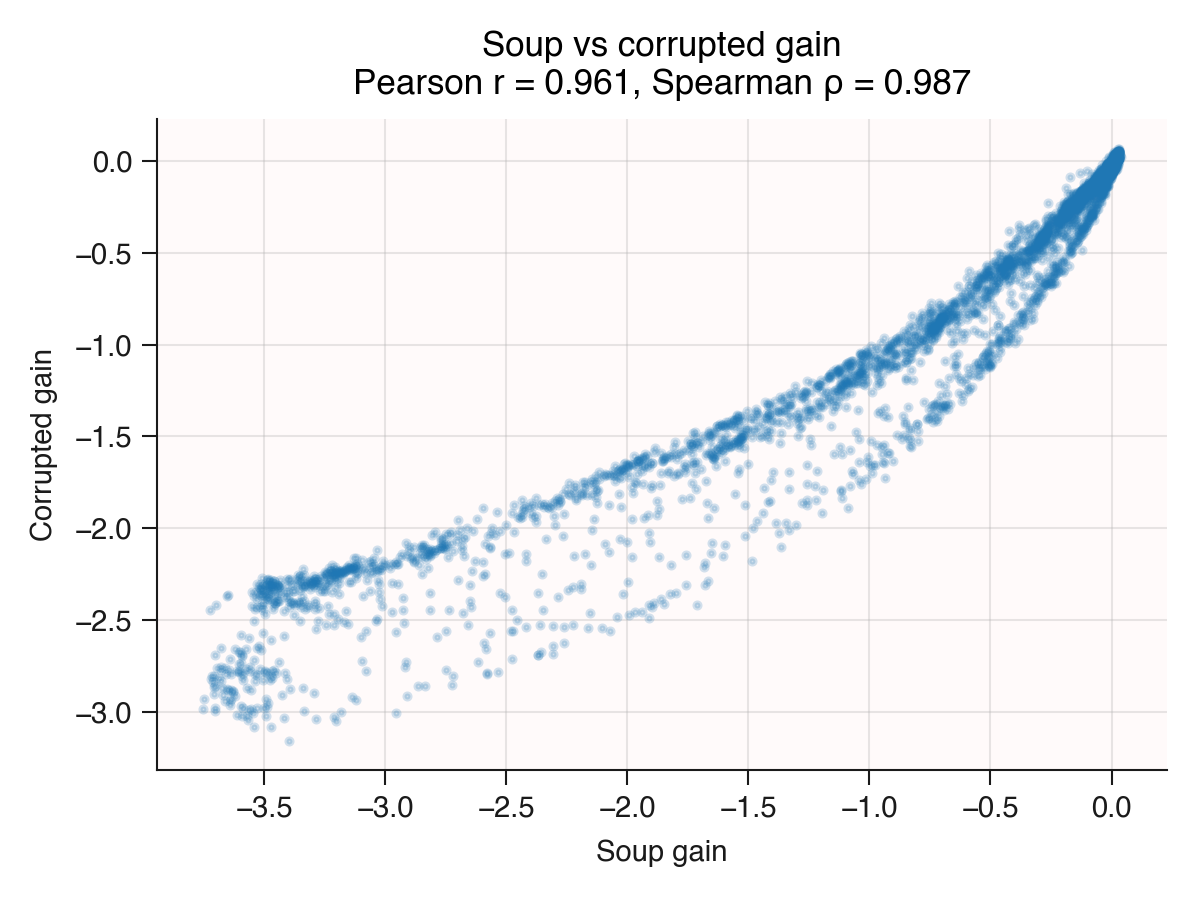

In [65]:
fig, ax = plt.subplots()

ax.scatter(x, y, alpha=0.2, s=2)

ax.set_xlabel('Soup gain')
ax.set_ylabel('Corrupted gain')
ax.set_title(
    f'Soup vs corrupted gain\n'
    f'Pearson r = {pearson_r:.3f}, Spearman ρ = {spearman_r:.3f}'
)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [66]:
soups['contains_variant_1'] = (soups['variant_a'] == 1) | (soups['variant_b'] == 1)
soups.groupby('contains_variant_1')[['soup_gain', 'corrupted_gain']].median()

,soup_gain,corrupted_gain
contains_variant_1,,
False,-0.284321,-0.456957
True,-3.643335,-0.962164


# Does souping help improve robustness
i.e. lower the gap

In [67]:
# Add robustness columns to soups
soups['robustness_a'] = soups['clean_loss_a'] - soups['corrupted_loss_a']
soups['robustness_b'] = soups['clean_loss_b'] - soups['corrupted_loss_b']
soups['robustness_soup'] = soups['clean_loss'] - soups['corrupted_loss']

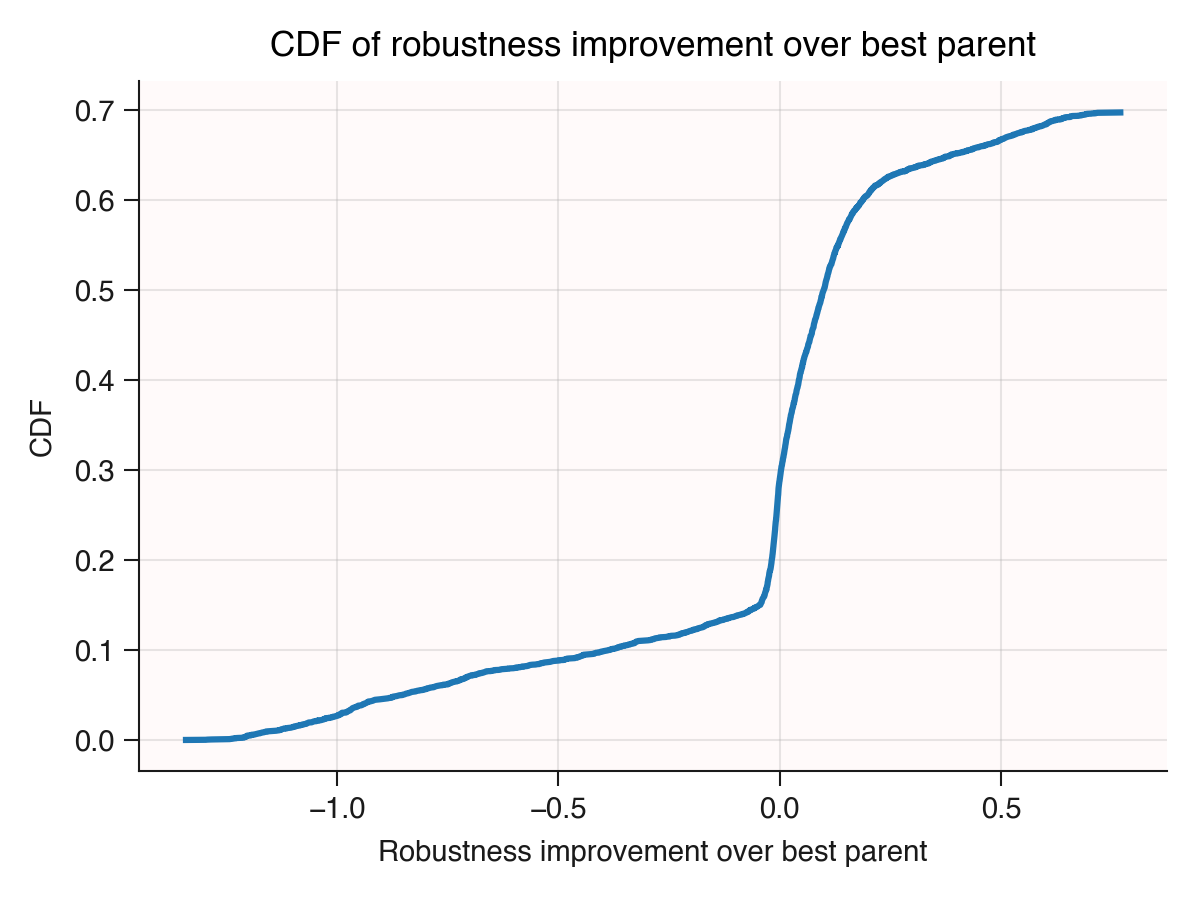

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Min robustness of parents
soups['robustness_min_parent'] = soups[['robustness_a', 'robustness_b']].min(axis=1)

# Difference: soup minus best parent
diff = soups['robustness_min_parent'] - soups['robustness_soup']

# Drop NaNs
# diff = diff.dropna().to_numpy()

# ECDF
diff_sorted = np.sort(diff)
y = np.arange(1, len(diff_sorted) + 1) / len(diff_sorted)

# Plot
fig, ax = plt.subplots()

ax.plot(diff_sorted, y)

ax.set_xlabel('Robustness improvement over best parent')
ax.set_ylabel('CDF')
ax.set_title('CDF of robustness improvement over best parent')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<Axes: >

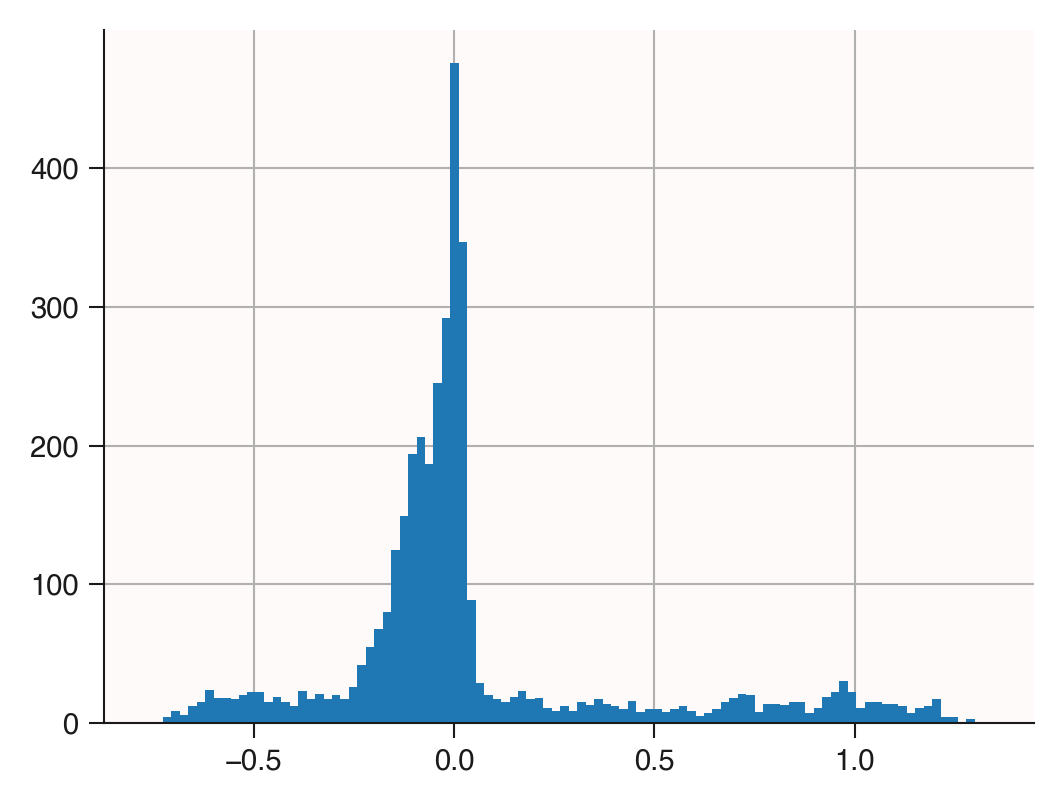

In [69]:
diff = pd.Series(diff)
diff.hist(bins=100)

In [74]:
diff.mean(), diff.median()

(np.float64(-0.04927360895880174), np.float64(0.02027666002072781))

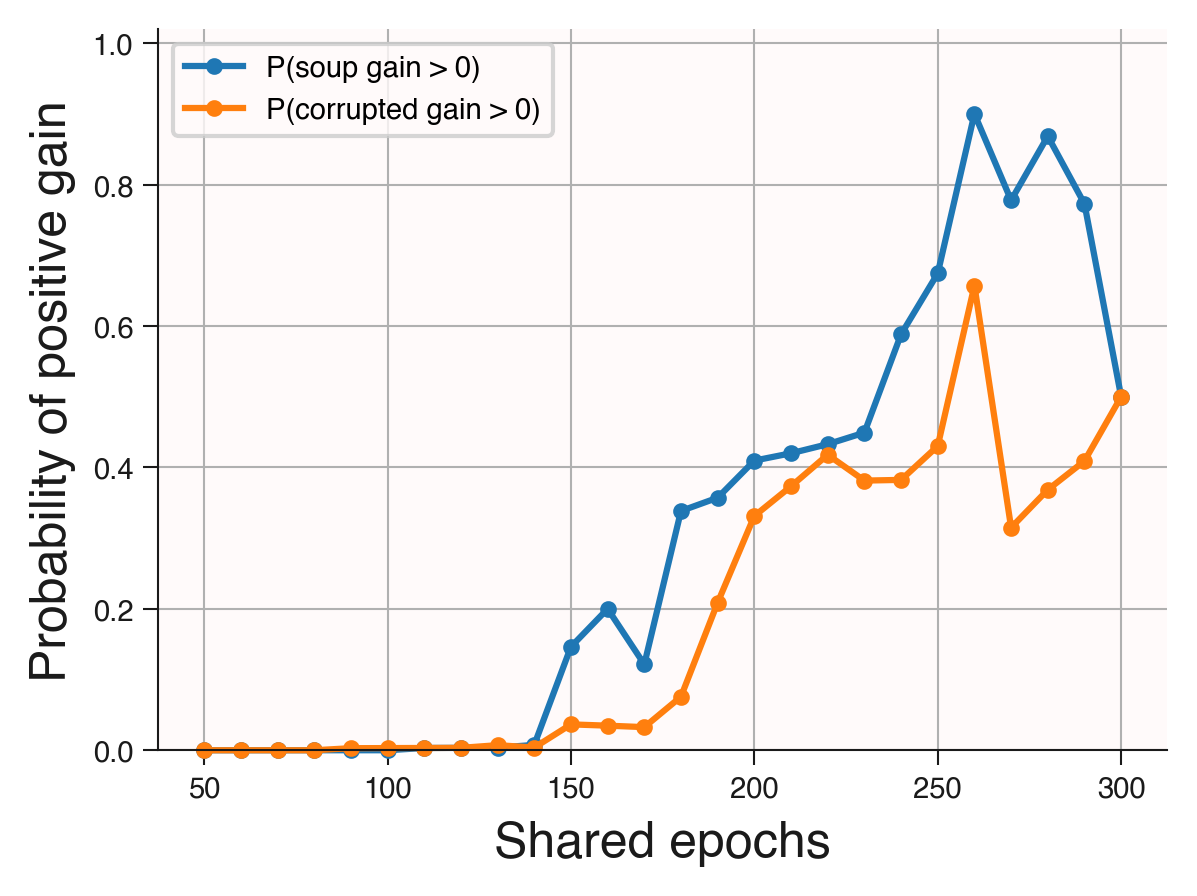

In [71]:
# Indicators for positive gains
soups['gain_positive_clean'] = soups['soup_gain'] >= 0
soups['gain_positive_corrupted'] = soups['corrupted_gain'] >= 0

# Probability of positive gain for each shared epoch count
prob_df = (
    soups
    .groupby('shared_epochs')[['gain_positive_clean', 'gain_positive_corrupted']]
    .mean()
    .reset_index()
    .rename(columns={
        'gain_positive_clean': 'prob_positive_clean',
        'gain_positive_corrupted': 'prob_positive_corrupted'
    })
)

fig, ax = plt.subplots()

ax.plot(
    prob_df['shared_epochs'],
    prob_df['prob_positive_clean'],
    marker='o',
    markersize=3,
    clip_on=False,
    label='P(soup gain > 0)'
)

ax.plot(
    prob_df['shared_epochs'],
    prob_df['prob_positive_corrupted'],
    marker='o',
    markersize=3,
    clip_on=False,
    label='P(corrupted gain > 0)'
)

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('Probability of positive gain', fontsize=12)
ax.set_ylim(0, 1.02)

ax.legend()
plt.tight_layout()
plt.show()
